<a id="up"></a>
# Colorful Traces notebook

Here is the notebook we used to do some exploration about the data

 - [Setup](#setup)
 - [data exploration](#data-exp)
 - [long lat extraction](#extr)

Please run setup if you want to run any of the subsections



<a id = 'setup'> </a>
## Setup 
[Table of Content](#up)

imports and useful functions

In [2]:
import pandas as pd 
from urllib.request import urlopen
import xmltodict
import json
import matplotlib as plt
%matplotlib inline

In [3]:
def buildOSMNodeToLatLngDictionary(allOsmNodes):
    d = {}
    for p in allOsmNodes:
        d[p] = getLatLng(p)
    return d

def getLatLng(osmNode):
    file = urlopen('https://api.openstreetmap.org/api/0.6/node/' + str(osmNode))
    data = file.read()
    file.close()
    data = xmltodict.parse(data)
    return data['osm']['node']['@lat'], data['osm']['node']['@lon']

<a id = 'data-exp'> </a>
## Data Exploration

[Table of Content](#up)


Here, we are doing some basic stats about the data to have more insight

In [4]:
colorful = pd.read_csv("data/dataviz.csv", parse_dates=True )
colorful["road"] = colorful["road"].map(eval)
colorful["LengthRoad"] = colorful["road"].map(lambda x : len(x))
colorful["pnode"] =colorful["road"].map(lambda x :x[0])
colorful["dnode"] =colorful["road"].map(lambda x :x[-1])
colorful = colorful.drop(columns=["plat", "plng", "dlat", "dlng"])
#colorful.to_csv("data/cleaned.csv")
colorful.head()

,t,road,LengthRoad,pnode,dnode
0,11:15:00,"[311463563, 2940544168, 311463564, 561463459, ...",61,311463563,567914227
1,20:00:00,"[311463563, 2940544168, 311463564, 561463459, ...",234,311463563,560972953
2,18:15:00,"[311463563, 2940544168, 311463564, 561463459, ...",346,311463563,3357408889
3,18:45:00,"[2223091605, 3786724165, 3786724164, 302530573...",125,2223091605,4601251537
4,19:00:00,"[3516999773, 3817926827, 567951313, 567951312,...",201,3516999773,1025496938


In [5]:
# Some stats about the 

from collections import Counter

counter =Counter()

def count_node(nodes):
    for n in nodes:
        counter[n] += 1
        
for nodes in colorful.road.tolist():
    count_node(nodes)



In [6]:
nodes = pd.DataFrame.from_dict(counter, orient="index", columns=["occurence"]).sort_values(by= "occurence", ascending=False)
nodes.head()

,occurence
2657469978,1103
155124152,1024
2223091605,996
2223091607,995
3786724226,995


In [7]:
# List of all nodes
allNodes = nodes.index.tolist()
len(allNodes)

12600

In [8]:
nodesToOccurencesDict = pd.Series(nodes.occurence,index=nodes.index.values).to_dict()

# Save Dictionary
with open('data/nodesToOccurences.json', 'w') as fp:
    json.dump(nodesToOccurencesDict, fp)

In [9]:
len(nodesToOccurencesDict.keys())

12600

In [10]:
nodes["tuple-unique"] = 1
t_unique = nodes.groupby("occurence").count().sort_values(by="tuple-unique", ascending =False)
t_unique["percentage"] = t_unique["tuple-unique"].map(lambda x : x/t_unique["tuple-unique"].sum() *100)
t_unique.head(10)

,tuple-unique,percentage
occurence,,
1,2901,23.023810
2,1953,15.500000
3,1047,8.309524
4,751,5.960317
6,705,5.595238
5,604,4.793651
7,509,4.039683
8,318,2.523810
10,256,2.031746


Text(0.5, 0, 'number of nodes that appears x-times')

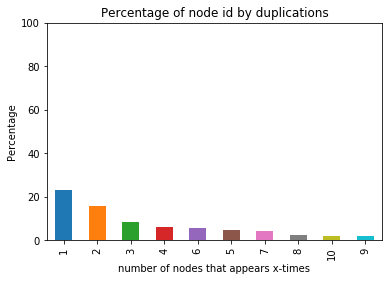

In [11]:
fig = t_unique["percentage"].head(10).plot.bar(ylim=[0, 100], title="Percentage of node id by duplications")
fig.yaxis.set_label_text("Percentage")
fig.xaxis.set_label_text("number of nodes that appears x-times")

In [12]:
pickup_group = colorful.groupby(by=["pnode"]).count().sort_values("road", ascending =False)

print("There are", len(pickup_group.index.tolist()), "different pickup locations.")

nb_pickups_by_pnode = pickup_group.drop(columns=["t", "road", "LengthRoad"])
nb_pickups_by_pnode = nb_pickups_by_pnode.rename(index=str, columns={"dnode": "nb of pickups"})
#nb_pickups_by_pnode = nb_pickups_by_pnode.drop(columns=["nb of pickups"])
#nb_pickups_by_pnode = nb_pickups_by_pnode.index.tolist()

There are 42 different pickup locations.


In [21]:
pickupToNbPickups = nb_pickups_by_pnode.to_dict()['nb of pickups']



# Save Dictionary
with open('data/pickupToNbPickups.json', 'w') as fp:
    json.dump(pickupToNbPickups, fp)

In [13]:
pickupToNbPickups = nb_pickups_by_pnode

In [14]:
# Save pickup nodes
nb_pickups_by_pnode.to_csv("data/pickupNodes.csv")



There are 525 different drop off locations.


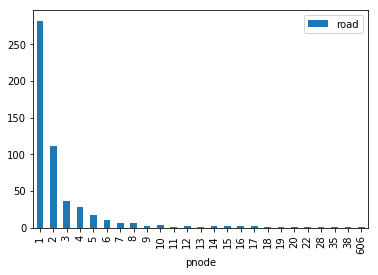

In [37]:
drop_off_group = colorful.groupby(by=["dnode"]).count().sort_values("road", ascending =False)

print("There are", len(drop_off_group.index.tolist()), "different drop off locations.")

nb_dropoffs_by_pnode = drop_off_group.drop(columns=["t",  "LengthRoad"])
#nb_dropoffs_by_pnode = nb_dropoffs_by_pnode.rename(index=str, columns={"pnode": "nb of x tuples dropoffs"})
   

nb_dropoffs_by_pnode.groupby("road").count()   
nb_dropoffs_by_pnode.groupby("pnode").count().plot.bar()

In [38]:
nb_dropoffs_by_pnode = nb_dropoffs_by_pnode.drop(columns=["road",  "pnode"])

# Save dropoff nodes
nb_pickups_by_pnode.to_csv("data/pickupNodes.csv")

One data point contains 6 attributs: `plat`, `plng`, `dlat`, `t`  and `road`. 

In [39]:
colorful.describe()

,LengthRoad,pnode,dnode
count,2000.000000,2.000000e+03,2.000000e+03
mean,210.462500,2.089708e+09,1.792157e+09
std,105.143822,1.506250e+09,1.541335e+09
min,12.000000,5.040500e+05,2.806610e+05
25%,123.000000,5.630213e+08,5.615095e+08
50%,190.500000,2.223092e+09,6.224273e+08
75%,316.000000,2.223092e+09,3.357409e+09
max,651.000000,5.542663e+09,5.623968e+09


In [40]:
colorful["LengthRoad"].describe()

count    2000.000000
mean      210.462500
std       105.143822
min        12.000000
25%       123.000000
50%       190.500000
75%       316.000000
max       651.000000
Name: LengthRoad, dtype: float64

<a id = 'extr'></a>
## Long Lat Extraction
[Table of Content](#up)


In this section, we are extracting the lattitude and the longitude of the node id presente in the path

In [41]:
# Building osm to lat and lng dictionary

# ATTENTION deleted nodes : allNodes[107:108],allNodes[136:137], allNodes[188:189], allNodes[211:212], allNodes[3281:3282], allNodes[3287:3288], allNodes[4049:4050], allNodes[5395:5396], allNodes[5949:5950], allNodes[5965:5966]
# allNodes[5976:5977], allNodes[5983:5984], allNodes[6165:6166], allNodes[6175:6176], allNodes[6177:6178], allNodes[7798:7799], allNodes[8625:8626], allNodes[8626:8627]
# allNodes[9089:9090], allNodes[9103:9104], allNodes[12252:12253], allNodes[12343:12344]

chunk = allNodes[12600:12600]
d = buildOSMNodeToLatLngDictionary(chunk)

# Load Dictionary
with open('data/OSMToLatLngDictionary2.json', 'r') as fp:
    data = json.load(fp)

newDict = {**d, **data}
    
# Save Dictionary
#with open('data/OSMToLatLngDictionary2.json', 'w') as fp:
#    json.dump(newDict, fp)

FileNotFoundError: [Errno 2] No such file or directory: 'data/OSMToLatLngDictionary2.json'

We found out that there are nodes that were removed from OSMMap present in the dataset.

There are listed bellow

In [42]:
nonexistentNodes = []
nonexistentNodes.append(allNodes[107:108][0])
nonexistentNodes.append(allNodes[136:137][0])
nonexistentNodes.append(allNodes[188:189][0])
nonexistentNodes.append(allNodes[211:212][0])
nonexistentNodes.append(allNodes[3281:3282][0])
nonexistentNodes.append(allNodes[3287:3288][0])
nonexistentNodes.append(allNodes[4049:4050][0])
nonexistentNodes.append(allNodes[5395:5396][0])
nonexistentNodes.append(allNodes[5949:5950][0])
nonexistentNodes.append(allNodes[5965:5966][0])

nonexistentNodes.append(allNodes[5976:5977][0])
nonexistentNodes.append(allNodes[5983:5984][0])
nonexistentNodes.append(allNodes[6165:6166][0])
nonexistentNodes.append(allNodes[6175:6176][0])
nonexistentNodes.append(allNodes[6177:6178][0])
nonexistentNodes.append(allNodes[7798:7799][0])
nonexistentNodes.append(allNodes[8625:8626][0])
nonexistentNodes.append(allNodes[8626:8627][0])

nonexistentNodes.append(allNodes[9089:9090][0])
nonexistentNodes.append(allNodes[9103:9104][0])
nonexistentNodes.append(allNodes[12252:12253][0])
nonexistentNodes.append(allNodes[12343:12344][0])
nonexistentNodes

[598114225,
 582463773,
 4174445898,
 565052160,
 580047011,
 580047012,
 331238069,
 312416320,
 660206860,
 5332973020,
 660206872,
 5230804614,
 289477434,
 565051397,
 565051398,
 582463774,
 621707601,
 621707598,
 423184563,
 376010056,
 621707593,
 4174445899]

In [44]:
print(len(newDict.keys()))
len(nonexistentNodes)

# With yields the total of 12'600 nodes

NameError: name 'newDict' is not defined

#### Withdrawing the non existent nodes

First make sure none of those are pickup or dropoff nodes

In [46]:

dest_arrival = set(colorful.pnode.tolist() + colorful.dnode.tolist())
presents = []
for nonexistentNode in nonexistentNodes:
    
    if nonexistentNode in dest_arrival:
        presents += [nonexistentNode]

print(presents)

[4174445899]


We will fix the one that is present in the pickoff or drop off manually.


In [47]:
for present in presents: 
    nonexistentNodes.remove(present)
    
def removeNodes(r, nodes):
    for n in nodes:
        if n in r:
            r.remove(n)
    return r

colorful['road'] = colorful['road'].map(lambda r: removeNodes(r, nonexistentNodes))

In [48]:

colorful['l'] = colorful['road'].map(len)

before = colorful[['l', 'LengthRoad']].sum().iloc[1]
after = colorful[['l', 'LengthRoad']].sum().iloc[0]
print("We are withdrawing {} nodes".format(before - after))
colorful[['t', 'road', 'LengthRoad', 'pnode', 'dnode']].to_csv("data/cleaned.csv")

We are withdrawing 2752 nodes


In [49]:
newDB = pd.read_csv("data/cleaned.csv", parse_dates=True )

In [50]:
newDB

,Unnamed: 0,t,road,LengthRoad,pnode,dnode
0,0,11:15:00,"[311463563, 2940544168, 311463564, 561463459, ...",61,311463563,567914227
1,1,20:00:00,"[311463563, 2940544168, 311463564, 561463459, ...",234,311463563,560972953
2,2,18:15:00,"[311463563, 2940544168, 311463564, 561463459, ...",346,311463563,3357408889
3,3,18:45:00,"[2223091605, 3786724165, 3786724164, 302530573...",125,2223091605,4601251537
4,4,19:00:00,"[3516999773, 3817926827, 567951313, 567951312,...",201,3516999773,1025496938
5,5,18:30:00,"[2223091605, 3786724165, 3786724164, 302530573...",316,2223091605,3357408889
6,6,18:00:00,"[311463563, 2940544168, 311463564, 561463459, ...",217,311463563,1722557098
7,7,20:15:00,"[2223091605, 3786724165, 3786724164, 302530573...",316,2223091605,3357408889
8,8,19:30:00,"[563021325, 3451982209, 667938188, 667938189, ...",202,563021325,621771831
9,9,19:15:00,"[311463563, 2940544168, 311463564, 561463459, ...",94,311463563,598565673


In [ ]:
colorful_cleaned = pd.read_csv("data/dataviz.csv", parse_dates=True )